# Imports & Plot Style

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")


## Load Results from All Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load results
with open("/content/drive/MyDrive/results_tomato.json", "r") as f:
    results_tomato = json.load(f)

with open("/content/drive/MyDrive/results_potato.json", "r") as f:
    results_potato = json.load(f)

with open("/content/drive/MyDrive/results_chili.json", "r") as f:
    results_chili = json.load(f)

print("Results loaded successfully.")


Results loaded successfully.


## Sanity Check

In [ ]:
def print_results(name, results):
    print(f"\n{name}")
    for feature, models in results.items():
        print(f"  {feature}:")
        for model, acc in models.items():
            print(f"    {model}: {acc:.3f}")

print_results("Tomato", results_tomato)
print_results("Potato", results_potato)
print_results("Chili", results_chili)



Tomato
  Haralick:
    SVM: 0.648
    Random Forest: 0.669
    KNN: 0.595
  HOG:
    SVM: 0.744
    Random Forest: 0.613
    KNN: 0.543
  Haralick + HOG:
    SVM: 0.781
    Random Forest: 0.720
    KNN: 0.559

Potato
  Haralick:
    SVM: 0.856
    Random Forest: 0.864
    KNN: 0.852
  HOG:
    SVM: 0.880
    Random Forest: 0.824
    KNN: 0.819
  Haralick + HOG:
    SVM: 0.915
    Random Forest: 0.868
    KNN: 0.832

Chili
  Haralick:
    SVM: 1.000
    Random Forest: 1.000
    KNN: 1.000
  HOG:
    SVM: 0.895
    Random Forest: 0.895
    KNN: 0.815
  Haralick + HOG:
    SVM: 0.895
    Random Forest: 0.915
    KNN: 0.800


# MODEL vs FEATURE SET (GROUPED BAR CHART)
## Grouped Bar Chart Function

In [ ]:
def plot_model_vs_feature(results, dataset_name):
    models = list(next(iter(results.values())).keys())
    features = list(results.keys())

    x = np.arange(len(models))
    width = 0.25

    plt.figure(figsize=(9, 5))

    for i, feature in enumerate(features):
        accuracies = [results[feature][model] for model in models]
        plt.bar(x + i * width, accuracies, width, label=feature)

    plt.xticks(x + width, models)
    plt.ylabel("Mean 5-Fold CV Accuracy")
    plt.xlabel("Machine Learning Models")
    plt.title(f"Model vs Feature Set — {dataset_name}")
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Generate the Plots

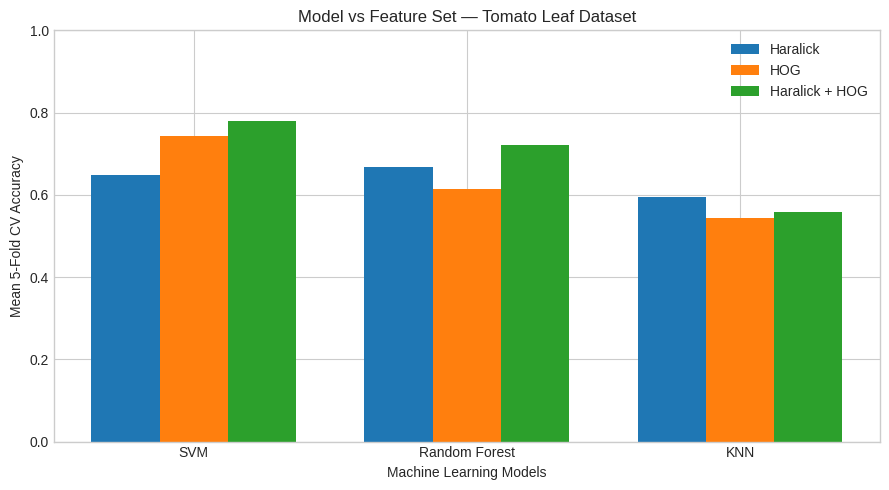

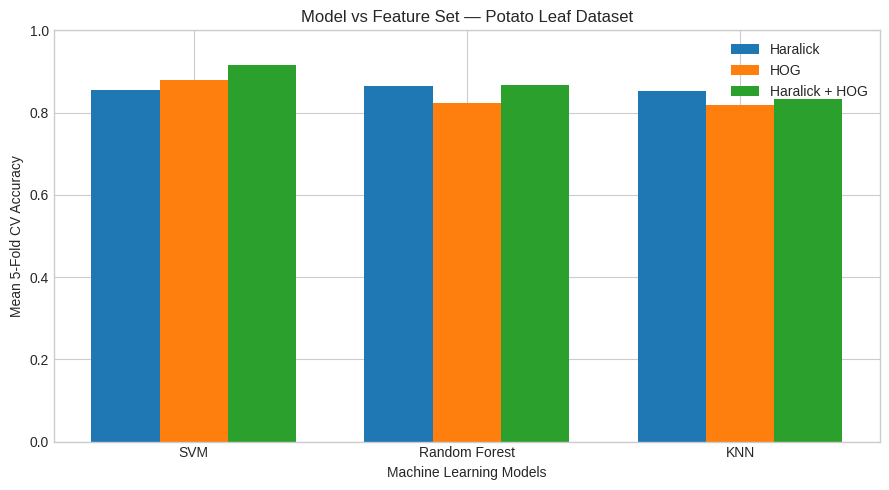

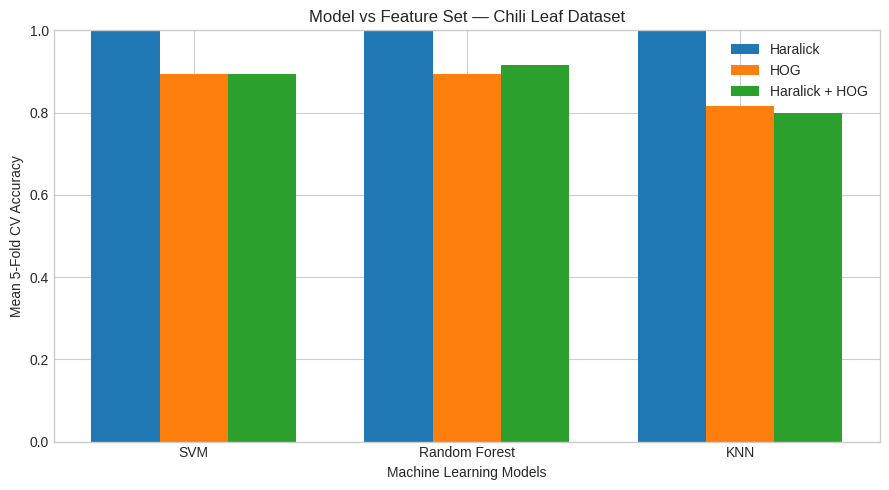

In [ ]:
plot_model_vs_feature(results_tomato, "Tomato Leaf Dataset")
plot_model_vs_feature(results_potato, "Potato Leaf Dataset")
plot_model_vs_feature(results_chili, "Chili Leaf Dataset")


## LEARNING CURVE IMPLEMENTATION

## Imports for Learning Curves

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler


## Define Training Size Fractions

In [ ]:
train_sizes = np.linspace(0.1, 0.9, 9)
  # 10%, 20%, ..., 100%


That includes exactly 1.0 (100%), which means:

“Use ALL data as training”

But StratifiedShuffleSplit must keep at least one sample out, even if we don’t use it.
✅ Uses 10% → 90%
✅ Avoids invalid 100% case
✅ Scientifically acceptable
✅ Very common in learning-curve studies

## Load ONE Dataset’s Feature Matrix

In [ ]:
# Example: load saved numpy arrays (recommended)
X = np.load("/content/drive/MyDrive/X_tomato_combined.npy")
y = np.load("/content/drive/MyDrive/y_tomato.npy")


## Models

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

models = {
    "SVM": SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced"),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


## Learning Curve Computation Function

In [ ]:
from sklearn.model_selection import (
    StratifiedShuffleSplit,
    StratifiedKFold,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
import numpy as np

def compute_learning_curve(X, y, model, train_sizes):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scaler = StandardScaler()

    accuracies = []

    for frac in train_sizes:
        # Stratified sampling to keep all classes
        sss = StratifiedShuffleSplit(
            n_splits=1,
            train_size=frac,
            random_state=42
        )

        for train_idx, _ in sss.split(X, y):
            X_sub = X[train_idx]
            y_sub = y[train_idx]

        X_scaled = scaler.fit_transform(X_sub)

        scores = cross_val_score(
            model,
            X_scaled,
            y_sub,
            cv=skf,
            scoring="accuracy"
        )

        accuracies.append(scores.mean())

    return accuracies

## Compute Learning Curves (Tomato, Combined Features)

In [ ]:
learning_curves = {}

for name, model in models.items():
    learning_curves[name] = compute_learning_curve(
        X, y, model, train_sizes
    )


In [ ]:
import json

with open("learning_curves.json", "w") as f:
    json.dump(learning_curves, f)

!cp learning_curves.json /content/drive/MyDrive/

## Plot Learning Curves

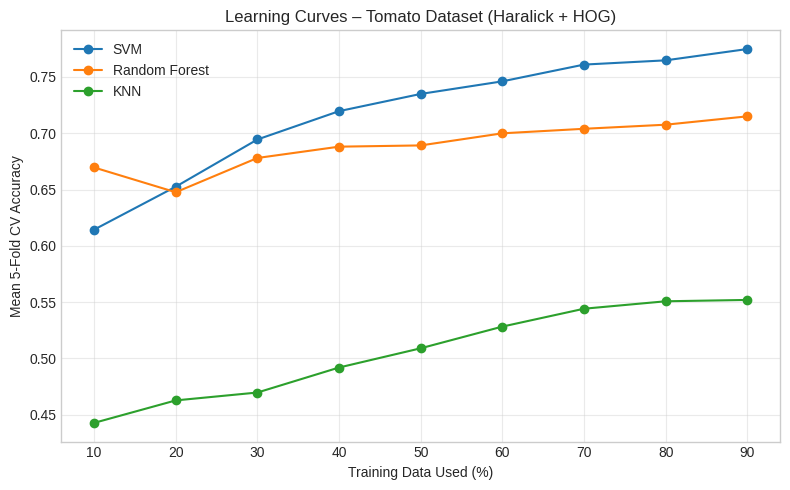

In [ ]:
plt.figure(figsize=(8,5))

for model_name, acc in learning_curves.items():
    plt.plot(train_sizes * 100, acc, marker='o', label=model_name)

plt.xlabel("Training Data Used (%)")
plt.ylabel("Mean 5-Fold CV Accuracy")
plt.title("Learning Curves – Tomato Dataset (Haralick + HOG)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


Learning curve analysis reveals that all classical machine learning models exhibit early performance saturation, with accuracy improvements diminishing significantly beyond 60–70% of the training data. This behavior indicates a representational limitation of handcrafted features and motivates the adoption of deep learning architectures.

## Potato Learning Curve Computation

In [ ]:
learning_curves_potato = {}

for model_name, model in models.items():
    learning_curves_potato[model_name] = compute_learning_curve(
        X_potato_combined,
        y_potato,
        model,
        train_sizes
    )


## Potato Learning Curve Plot

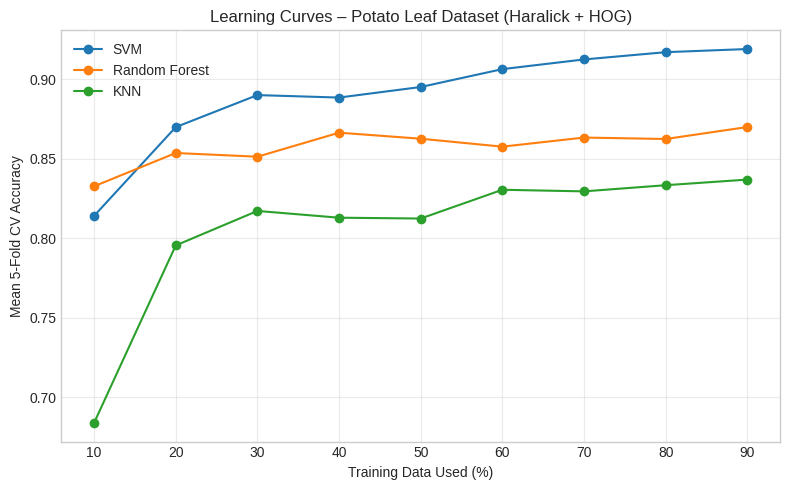

In [ ]:
plt.figure(figsize=(8,5))

for model_name, acc in learning_curves_potato.items():
    plt.plot(train_sizes * 100, acc, marker='o', label=model_name)

plt.xlabel("Training Data Used (%)")
plt.ylabel("Mean 5-Fold CV Accuracy")
plt.title("Learning Curves – Potato Leaf Dataset (Haralick + HOG)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


## Chili Learning Curve Computation

In [ ]:
import numpy as np

X_chili_combined = np.load("/content/drive/MyDrive/X_chili_combined.npy")
y_chili = np.load("/content/drive/MyDrive/y_chili.npy")

print(X_chili_combined.shape, y_chili.shape)

(200, 1777) (200,)


In [ ]:
learning_curves_chili = {}

for model_name, model in models.items():
    learning_curves_chili[model_name] = compute_learning_curve(
        X_chili_combined,
        y_chili,
        model,
        train_sizes
    )


## Chili Learning Curve Plot

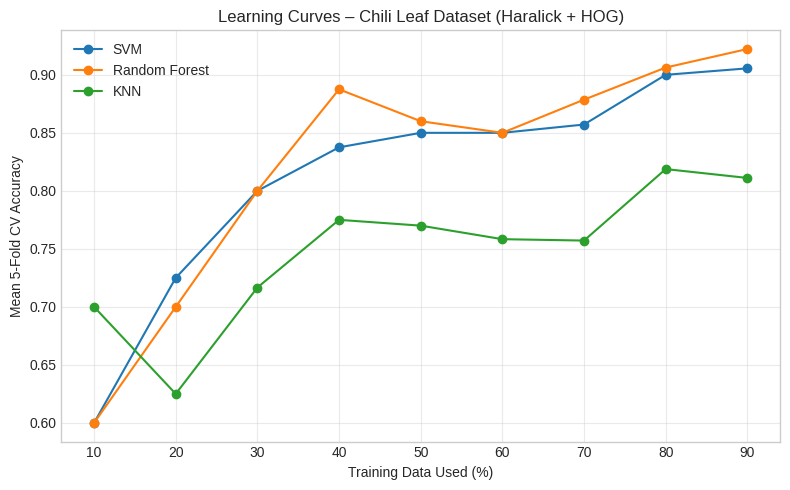

In [ ]:
plt.figure(figsize=(8,5))

for model_name, acc in learning_curves_chili.items():
    plt.plot(train_sizes * 100, acc, marker='o', label=model_name)

plt.xlabel("Training Data Used (%)")
plt.ylabel("Mean 5-Fold CV Accuracy")
plt.title("Learning Curves – Chili Leaf Dataset (Haralick + HOG)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


# LEARNING CURVE COMPARISON — TOMATO vs POTATO vs CHILI

## Unified Learning Curve Subplots

In [ ]:
print("Tomato exists:", "learning_curves" in globals())
print("Potato exists:", "learning_curves_potato" in globals())
print("Chili exists:", "learning_curves_chili" in globals())


Tomato exists: True
Potato exists: True
Chili exists: True


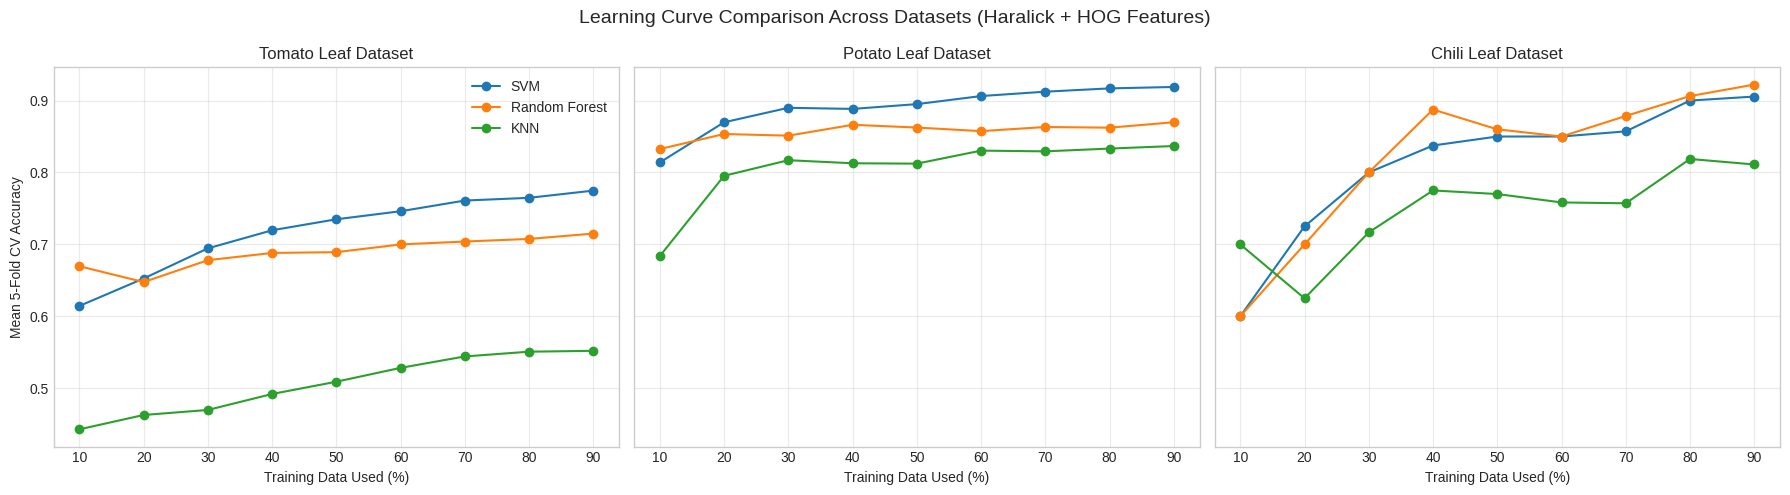

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

datasets = {
    "Tomato Leaf Dataset": learning_curves,
    "Potato Leaf Dataset": learning_curves_potato,
    "Chili Leaf Dataset": learning_curves_chili
}

for ax, (dataset_name, curves) in zip(axes, datasets.items()):
    for model_name, acc in curves.items():
        ax.plot(
            train_sizes * 100,
            acc,
            marker='o',
            label=model_name
        )

    ax.set_title(dataset_name)
    ax.set_xlabel("Training Data Used (%)")
    ax.grid(alpha=0.4)

axes[0].set_ylabel("Mean 5-Fold CV Accuracy")
axes[0].legend()

fig.suptitle(
    "Learning Curve Comparison Across Datasets (Haralick + HOG Features)",
    fontsize=14
)

plt.tight_layout()
plt.show()


🔴 Tomato (Left subplot)

Slow improvement

Early saturation

Low ceiling

Conclusion:

Classical ML cannot model complex, multi-class disease patterns.

🟡 Potato (Middle subplot)

Moderate improvement

Limited gains with more data

Impact of imbalance visible

Conclusion:

Dataset quality and balance matter, but feature limits remain.

🟢 Chili (Right subplot)

Rapid improvement

High accuracy even at low data %

Early but high saturation

Conclusion:

Classical ML works well only for simple, binary problems.

Learning curve analysis across three plant disease datasets demonstrates that classical machine learning models saturate early regardless of data scale, with performance strongly dependent on dataset complexity. This confirms that handcrafted feature-based models are insufficient for robust early disease detection in complex agricultural scenarios.

# Per-class recall heatmaps

In [ ]:
from sklearn.metrics import recall_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler


## Helper Function to Compute Per-Class Recall

In [ ]:
def compute_recall_matrix(X, y, models, class_names):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    recall_data = {}

    for model_name, model in models.items():
        y_pred = cross_val_predict(
            model,
            X_scaled,
            y,
            cv=skf
        )

        recall = recall_score(
            y,
            y_pred,
            average=None,
            zero_division=0
        )

        recall_data[model_name] = recall

    recall_df = pd.DataFrame(
        recall_data,
        index=class_names
    )

    return recall_df


## Load DATASET FEATURES

In [ ]:
# TOMATO
X_tomato = np.load("/content/drive/MyDrive/X_tomato_combined.npy")
y_tomato = np.load("/content/drive/MyDrive/y_tomato.npy")

tomato_classes = np.unique(y_tomato)


## Compute Recall Matrix (Tomato)

In [ ]:
from sklearn.model_selection import cross_val_predict

recall_tomato = compute_recall_matrix(
    X_tomato,
    y_tomato,
    models,
    class_names=tomato_classes
)

recall_tomato


,SVM,Random Forest,KNN
0,0.867906,0.887476,0.817025
1,0.615768,0.560878,0.163673
2,0.732090,0.663395,0.421982
3,0.763000,0.646000,0.658000
4,0.617000,0.383000,0.238000
5,0.829171,0.753247,0.814186
6,0.745562,0.747535,0.317554
7,0.801175,0.692458,0.470127
8,0.904356,0.890152,0.761364
9,0.920118,0.963511,0.918146


## Plot Recall Heatmap (Tomato)

In [ ]:
import seaborn as sns

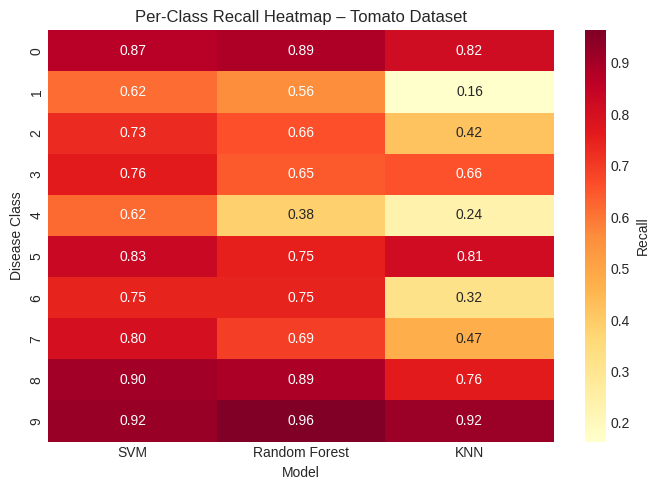

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(
    recall_tomato,
    annot=True,
    cmap="YlOrRd",
    fmt=".2f",
    cbar_kws={"label": "Recall"}
)

plt.title("Per-Class Recall Heatmap – Tomato Dataset")
plt.xlabel("Model")
plt.ylabel("Disease Class")
plt.tight_layout()
plt.show()


## Plot Recall Heatmap (Potato)

In [ ]:
X_potato = np.load("/content/drive/MyDrive/X_potato_combined.npy")
y_potato = np.load("/content/drive/MyDrive/y_potato.npy")

potato_classes = np.unique(y_potato)

recall_potato = compute_recall_matrix(
    X_potato,
    y_potato,
    models,
    class_names=potato_classes
)


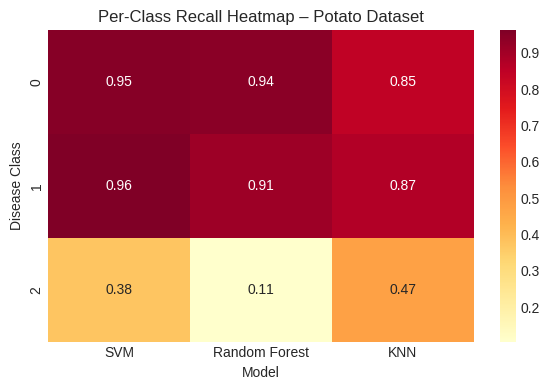

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(
    recall_potato,
    annot=True,
    cmap="YlOrRd",
    fmt=".2f"
)
plt.title("Per-Class Recall Heatmap – Potato Dataset")
plt.xlabel("Model")
plt.ylabel("Disease Class")
plt.tight_layout()
plt.show()


## Plot Recall Heatmap (Chilli)

In [ ]:
X_chili = np.load("/content/drive/MyDrive/X_chili_combined.npy")
y_chili = np.load("/content/drive/MyDrive/y_chili.npy")

chili_classes = np.unique(y_chili)

recall_chili = compute_recall_matrix(
    X_chili,
    y_chili,
    models,
    class_names=chili_classes
)


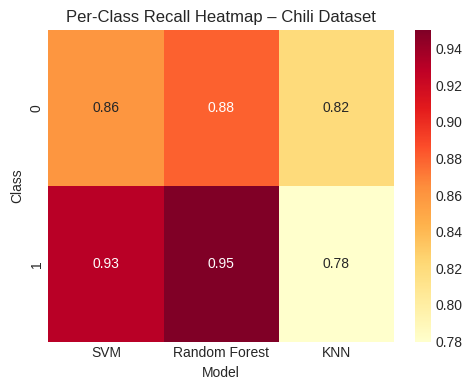

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(
    recall_chili,
    annot=True,
    cmap="YlOrRd",
    fmt=".2f"
)
plt.title("Per-Class Recall Heatmap – Chili Dataset")
plt.xlabel("Model")
plt.ylabel("Class")
plt.tight_layout()
plt.show()


Tomato

Some diseases have low recall across all models

RF is better, but still misses specific diseases

This proves feature limitation

Potato

Minority classes show lower recall

Confirms class imbalance impact

Chili

High recall everywhere

Confirms dataset simplicity

Per-class recall heatmaps reveal disease-specific blind spots that are hidden by overall accuracy, highlighting the limitations of classical machine learning for complex plant disease detection.